In [1]:
import dask.dataframe as dd

# which countries share common trade volumns(value and quanity)

In [2]:
from dask.distributed import Client, progress

client = Client(n_workers=2, threads_per_worker=2, memory_limit='5GB')
client

D:\anacond\lib\site-packages\distributed\node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59001 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:59001/status,
Dashboard: http://127.0.0.1:59001/status,Workers: 2
Total threads: 4,Total memory: 9.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59002,Workers: 2
Dashboard: http://127.0.0.1:59001/status,Total threads: 4
Started: Just now,Total memory: 9.31 GiB
Comm: tcp://127.0.0.1:59017,Total threads: 2
Dashboard: http://127.0.0.1:59019/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:59006,


In [3]:
directory_path = './trade data/trade_data/'

# Generate the file pattern for the years 1975 to 2000
file_pattern = directory_path + 'BACI_HS12_Y{year}_V202001.csv'

file_patterns = [file_pattern.format(year=year) for year in range(2016, 2019)]

df = dd.read_csv(file_patterns,assume_missing=True)

df

,t,i,j,k,v,q
npartitions=16,,,,,,
,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [4]:
import pandas as pd
products = pd.read_csv('./trade data/trade_data/product_codes_HS12_V202001.csv',encoding='latin-1')
products = products.rename(columns={"code":"k"})
df_wdes = df.merge(products)

countries = pd.read_csv('./trade data/trade_data/country_codes_V202001.csv',encoding='latin-1')
countries = countries.rename(columns={"country_code":"i","country_name_full":"name_i"})
df_wdes = df_wdes.merge(countries[['i','name_i']])

countries = pd.read_csv('./trade data/trade_data/country_codes_V202001.csv',encoding='latin-1')
countries = countries.rename(columns={"country_code":"j","country_name_full":"name_j"})
df_wdes = df_wdes.merge(countries[['j','name_j']])

In [5]:
df_wdes.head()

,t,i,j,k,v,q,description,name_i,name_j
0,2016.0,4.0,12.0,80132.0,26.313,3.000,"Nuts, edible: cashew nuts, fresh or dried, she...",Afghanistan,Algeria
1,2016.0,4.0,12.0,130190.0,1.507,0.585,"Natural gums, resins, gum-resins and oleoresin...",Afghanistan,Algeria
2,2016.0,4.0,12.0,370239.0,1.121,0.003,"Photographic film: in rolls, (other than with ...",Afghanistan,Algeria
3,2016.0,4.0,12.0,970600.0,17.236,0.019,Antiques: of an age exceeding one hundred years,Afghanistan,Algeria
4,2016.0,8.0,12.0,611020.0,1.226,0.035,"Jerseys, pullovers, cardigans, waistcoats and ...",Albania,Algeria


In [6]:
# Assuming df_wdes is your Dask DataFrame
# Aggregate export values by exporter country code 'i'
export_agg = df_wdes.groupby('name_i')['v'].mean().compute()  # Mean export value per exporter country

# Aggregate import values by importer country code 'j'
import_agg = df_wdes.groupby('name_j')['v'].mean().compute()  # Mean import value per importer country

# Convert these series to a DataFrame
import pandas as pd
export_df = export_agg.to_frame(name='avg_export_value')
import_df = import_agg.to_frame(name='avg_import_value')

# Merge the two dataframes on country code, which might be either 'i' or 'j'
trade_patterns = pd.merge(export_df, import_df, left_index=True, right_index=True, how='outer').fillna(0)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
trade_patterns_scaled = scaler.fit_transform(trade_patterns)

D:\anacond\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anacond\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anacond\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anacond\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

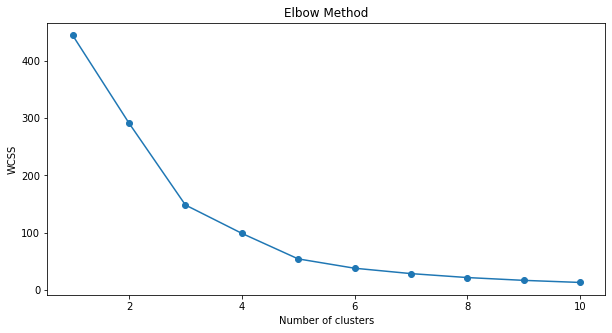

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):  # testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(trade_patterns_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply K-means
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(trade_patterns_scaled)

# Adding cluster labels to the dataframe
trade_patterns['cluster'] = clusters

D:\anacond\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


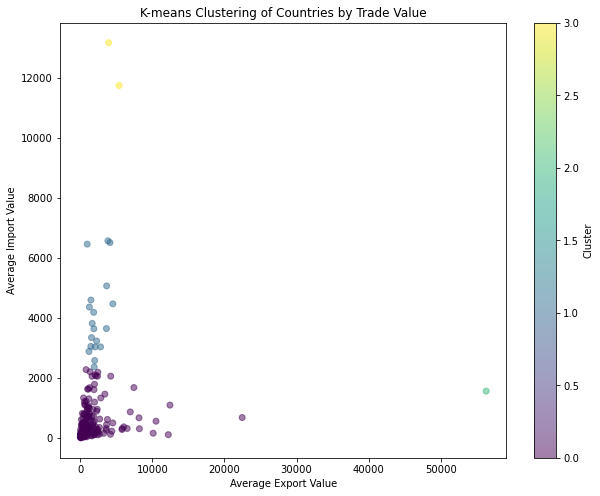

In [10]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(trade_patterns['avg_export_value'], trade_patterns['avg_import_value'], c=trade_patterns['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Average Export Value')
plt.ylabel('Average Import Value')
plt.title('K-means Clustering of Countries by Trade Value')
plt.colorbar(label='Cluster')
plt.show()

In [11]:
cluster_0_countries = trade_patterns[trade_patterns['cluster'] == 0].index.tolist()
print("Countries in Cluster 0:",cluster_0_countries)

cluster_1_countries = trade_patterns[trade_patterns['cluster'] == 1].index.tolist()
print("Countries in Cluster 1:",cluster_1_countries)

cluster_2_countries = trade_patterns[trade_patterns['cluster'] == 2].index.tolist()
print("Countries in Cluster 2:",cluster_2_countries)

cluster_3_countries = trade_patterns[trade_patterns['cluster'] == 3].index.tolist()
print("Countries in Cluster 3:",cluster_3_countries)

Countries in Cluster 0: ['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bonaire, Saint Eustatius and Saba', 'Bosnia Herzegovina', 'Brazil', 'British Indian Ocean Territories', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China, Macao Special Administrative Region', 'Christmas Islands', 'Cocos Islands', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czechia', "Côte d'Ivoire", "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea'

In [12]:
# Import numpy for statistical computations
import numpy as np

# Create a DataFrame to store cluster-wise statistics
cluster_stats = pd.DataFrame(columns=['Cluster', 'Num_countries', 'Mean_avg_export_value', 'Mean_avg_import_value'])

# Iterate over each cluster label
for cluster_label in trade_patterns['cluster'].unique():
    # Filter countries belonging to the current cluster
    cluster_countries = trade_patterns[trade_patterns['cluster'] == cluster_label]
    
    # Compute statistics for export and import values
    mean_export_value = cluster_countries['avg_export_value'].mean()
    mean_import_value = cluster_countries['avg_import_value'].mean()
    num_countries = len(cluster_countries)
    
    # Append cluster statistics to the DataFrame
    cluster_stats = cluster_stats.append({'Cluster': cluster_label,
                                          'Num_countries': num_countries,
                                          'Mean_avg_export_value': mean_export_value,
                                          'Mean_avg_import_value': mean_import_value},
                                         ignore_index=True)

# Print cluster-wise statistics
print(cluster_stats)

  Cluster Num_countries Mean_avg_export_value Mean_avg_import_value
0     0.0         200.0             1548.9607            479.741741
1     1.0          19.0           2322.916832           4046.767742
2     3.0           2.0           4664.229702          12459.145678
3     2.0           1.0          56294.536931           1563.499801


C:\Users\huawei\AppData\Local\Temp\ipykernel_18796\1665729313.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_stats = cluster_stats.append({'Cluster': cluster_label,
C:\Users\huawei\AppData\Local\Temp\ipykernel_18796\1665729313.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_stats = cluster_stats.append({'Cluster': cluster_label,
C:\Users\huawei\AppData\Local\Temp\ipykernel_18796\1665729313.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_stats = cluster_stats.append({'Cluster': cluster_label,
C:\Users\huawei\AppData\Local\Temp\ipykernel_18796\1665729313.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

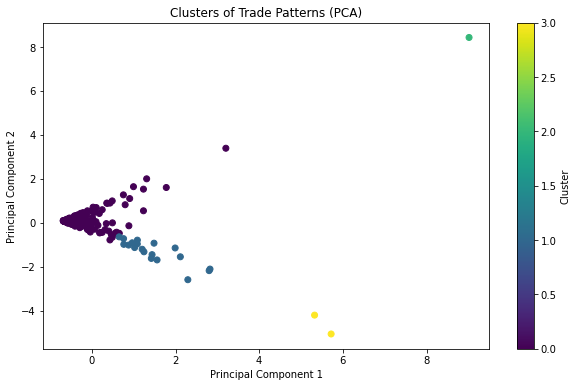

In [13]:
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
trade_patterns_pca = pca.fit_transform(trade_patterns_scaled)

# Plotting clusters after PCA
plt.figure(figsize=(10, 6))
plt.scatter(trade_patterns_pca[:, 0], trade_patterns_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters of Trade Patterns (PCA)')
plt.colorbar(label='Cluster')
plt.show()

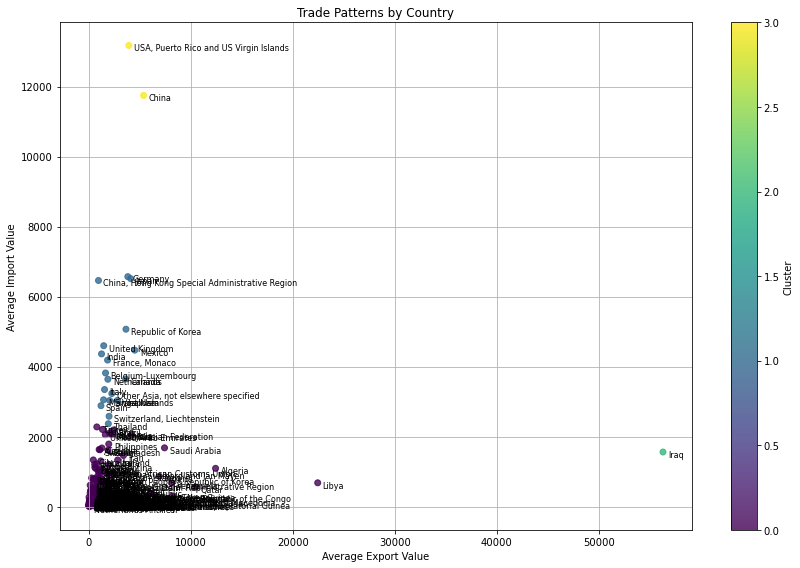

In [14]:
# Plotting trade patterns
plt.figure(figsize=(12, 8))

# Plot average export vs. average import for each country
plt.scatter(trade_patterns['avg_export_value'], trade_patterns['avg_import_value'], c=clusters, cmap='viridis', alpha=0.8)

# Add labels and title
plt.xlabel('Average Export Value')
plt.ylabel('Average Import Value')
plt.title('Trade Patterns by Country')

# Add a colorbar to show clusters
plt.colorbar(label='Cluster')

# Annotate countries for better understanding
for country, x, y in zip(trade_patterns.index, trade_patterns['avg_export_value'], trade_patterns['avg_import_value']):
    plt.annotate(country, (x, y), textcoords="offset points", xytext=(5,-5), ha='left', fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()